# NMA CN Project

- **Pod**: careful wolfs ⚠️🐺
- **Question**: is there a difference in neural activation at the cell level following stimulus presentation in the active vs passive conditions?

## Imports

In [1]:
# Only for Colab
#!python -m pip install --upgrade pip
#!pip install allensdk

In [2]:
import copy
from pathlib import Path
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import zscore
import seaborn as sns
from tqdm import tqdm

import allensdk
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

/home/seungjaeryanlee/anaconda3/envs/nma-cn/lib/python3.8/site-packages/allensdk/brain_observatory/session_api_utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Setup AllenSDK

In [3]:
!mkdir -p allensdk_storage
DATA_STORAGE_DIRECTORY = Path("./allensdk_storage")

In [4]:
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=DATA_STORAGE_DIRECTORY)

In [5]:
experiments_df = cache.get_ophys_experiment_table()

## Filter `experiments_df`

In [6]:
PROJECT_CODE = "VisualBehavior"
FULL_GENOTYPE = "Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt"

In [7]:
filtered_experiments_df = experiments_df.query("project_code == @PROJECT_CODE") \
                                        .query("full_genotype == @FULL_GENOTYPE")

## General Helper Functions
- `get_cell_specimen_ids(experiment)`
- `get_indices_in_interval(experiment, start, end)`
- `get_timestamps_in_interval(experiment, start, end)`
- `get_cell_dff_in_interval(experiment, cell_specimen_id, start, end)`

In [8]:
def get_cell_specimen_ids(experiment):
    """
    Get all the cell specimen ids recorded in the experiment.
    """
    return experiment.dff_traces.index

In [9]:
def get_indices_in_interval(experiment, start, end):
    """
    Get all indices of timestamps where dF/F trace was recorded during a specified interval.
    """
    indices = np.argwhere((experiment.ophys_timestamps >= start) & (experiment.ophys_timestamps <= end))[:, 0]
    return indices

In [10]:
def get_timestamps_in_interval(experiment, start, end):
    """
    Get all timestamps when dF/F trace was recorded during a specified interval.
    """
    indices = get_indices_in_interval(experiment, start, end)
    return experiment.ophys_timestamps[indices]

In [11]:
def get_cell_dff_in_interval(experiment, cell_specimen_id, start, end):
    """
    Get dF/F trace for one cell during a specified interval.
    """
    indices = get_indices_in_interval(experiment, start, end)
    return experiment.dff_traces.loc[cell_specimen_id]["dff"][indices[0]:indices[-1]+1]

## Compute Representational Dissimilarity Matrix (RDM)

$$ RDM = 1-\frac{1}{N} ZZ^T $$
- $Z$: z-scored response matrix with rows $r^{(s)}$ for each stimulus
- $N$: Number of neurons
- [Related tutorial](https://compneuro.neuromatch.io/tutorials/W2D1_DeepLearning/student/W2D1_Tutorial3.html#section-2-1-representational-dissimilarity-matrix-rdm)

### RDM Helper Functions
- `add_metadata_to_dict(experiments_dict)`
- `add_RDM_to_dict(experiments_dict)`
  - `calculate_RDM(experiment, f_agg=np.mean, start_timedelta=0, end_timedelta=0.25)`
- `plot_RDM_with_dict(experiments_dict, cmap="RdYlBu_r", save_dir="logs/RDM", save_fig_as=None)`
- `save_dict(experiments_dict, save_dir="logs/RDM", save_prefix=None)`
- `load_dict(filepath)`
- `get_RDM_correlation(rdm1, rdm2)`
- `plot_RDM_correlations_with_dict(experiments_dict, base_experiment_key)`

In [18]:
def add_metadata_to_dict(experiments_dict):
    """
    Add experiment metadata to each experiment in the given dictionary.
    """
    global experiments_df

    experiments_dict = copy.deepcopy(experiments_dict)

    for experiment_dict in experiments_dict.values():
        experiment_id = experiment_dict["experiment_id"]
        experiment_dict["mouse_id"] = experiments_df.loc[experiment_id]["mouse_id"]
        experiment_dict["session_type"] = experiments_df.loc[experiment_id]["session_type"]

    return experiments_dict

In [ ]:
def add_RDM_to_dict(experiments_dict):
    """
    Compute and add RDM for each experiment in the given dictionary.
    """
    experiments_dict = copy.deepcopy(experiments_dict)

    for experiment_dict in tqdm(experiments_dict.values()):
        experiment = cache.get_behavior_ophys_experiment(experiment_dict["experiment_id"])
        RDM = calculate_RDM(
            experiment,
            f_agg=experiment_dict["f_agg"],
            start_timedelta=experiment_dict["start_timedelta"],
            end_timedelta=experiment_dict["end_timedelta"],
        )
        experiment_dict["RDM"] = RDM

    return experiments_dict

In [ ]:
def calculate_RDM(experiment, f_agg=np.mean, start_timedelta=0, end_timedelta=0.25):
    """
    Calculate the RDM.
    """
    # Matrix of all recorded dff values (shape: #cells x #timestamps)
    dff_matrix = np.vstack(experiment.dff_traces.dff.values)

    # Matrix of all unnormalized responses (shape: #stimulus_presentations x #cells)
    response_matrix = []
    response_vectors = []
    for stimulus_name in experiment.stimulus_presentations.query("not omitted")["image_name"].unique():
        stimulus_start_times = experiment.stimulus_presentations.query('image_name == @stimulus_name')["start_time"]

        # Vector of aggregated (mean/max) dff values of all cells for all stimulus presentations
        # (shape: #stimulus_presentations x #cells)
        listof_population_agg_dff_in_interval = []
        for stimulus_start_time in stimulus_start_times:
            indices = get_indices_in_interval(
                experiment,
                start=stimulus_start_time + start_timedelta,
                end=stimulus_start_time + end_timedelta,
            )
            # Matrix of recorded dff values of all cells for particular interval
            # (shape: #cells x #timestamps_in_interval)
            population_dff_in_interval = dff_matrix[:, indices]
            # Vector of aggregated (mean/max) dff values of all cells for particular interval (shape: #cells)
            population_agg_dff_in_interval = f_agg(population_dff_in_interval, axis=1)
            listof_population_agg_dff_in_interval.append(population_agg_dff_in_interval)
        # Vector of aggregated (mean/max) dff values averaged for all stimulus presentations
        response_vector = np.mean(np.vstack(listof_population_agg_dff_in_interval), axis=0)
        response_vectors.append(response_vector)
    response_matrix = np.vstack(response_vectors)

    # Compute RDM
    zscored_response_matrix = zscore(response_matrix, axis=1)
    RDM = 1 - (zscored_response_matrix @ zscored_response_matrix.T) / zscored_response_matrix.shape[1]

    return RDM

In [20]:
def plot_RDM_with_dict(experiments_dict, cmap="RdYlBu_r", save_dir="logs/RDM", save_fig_as=None):
    """
    Plot the RDMs inside the given dictionary of experiments.
    """
    fig, axs = plt.subplots(1, len(experiments_dict), figsize=(4.5 * len(experiments_dict), 3.5))

    for i, experiment_dict in enumerate(experiments_dict.values()):
        ax = axs[i] if len(experiments_dict) > 1 else axs
        experiment_id = experiment_dict["experiment_id"]
        f_agg = experiment_dict["f_agg"]
        start_timedelta = experiment_dict["start_timedelta"]
        end_timedelta = experiment_dict["end_timedelta"]
        RDM = experiment_dict["RDM"]
        mouse_id = experiment_dict["mouse_id"]
        session_type = experiment_dict["session_type"]

        sns.heatmap(RDM, ax=ax, cmap=cmap, vmin=0.0, vmax=1.0)
        ax.set_title(f"{session_type}\nMOUSE_ID={mouse_id}\nEXPERIMENT_ID={experiment_id}\nF_AGG={f_agg.__name__}, INTERVAL=({start_timedelta},{end_timedelta})")

    # Save plot
    os.makedirs(save_dir, exist_ok=True)
    timestamp = f"t={int(time.time())}"
    if save_fig_as is None:
        save_fig_as = timestamp
    fig.savefig(f"{save_dir}/{save_fig_as}.png", bbox_inches="tight", pad_inches=0)
    print(f"Plot saved to {save_dir}/{save_fig_as}.png")

In [21]:
def save_dict(experiments_dict, save_dir="logs/RDM", save_prefix=None):
    os.makedirs(save_dir, exist_ok=True)
    timestamp = f"t={int(time.time())}"
    if save_prefix is None:
        save_prefix = timestamp
    for key, experiment_dict in experiments_dict.items():
        experiment_id = experiment_dict["experiment_id"]
        f_agg = experiment_dict["f_agg"]
        start_timedelta = experiment_dict["start_timedelta"]
        end_timedelta = experiment_dict["end_timedelta"]

        with open(f"{save_dir}/{save_prefix}_{key}_{experiment_id}_{f_agg.__name__}_{start_timedelta}_{end_timedelta}.dict", "wb") as f:
            pickle.dump(experiment_dict, f)
            print(f"Dict saved to {save_dir}/{save_prefix}_{key}_{experiment_id}_{f_agg.__name__}_{start_timedelta}_{end_timedelta}.dict")

In [22]:
def load_dict(filepath):
    with open(filepath, "rb") as f:
        experiment_dict = pickle.load(f)

    return experiment_dict

In [ ]:
def get_RDM_correlation(rdm1, rdm2):
    """Correlate off-diagonal elements of two RDM's

    Args:
    rdm1 (np.ndarray): S x S representational dissimilarity matrix
    rdm2 (np.ndarray): S x S representational dissimilarity matrix to
    correlate with rdm1

    Returns:
    float: correlation coefficient between the off-diagonal elements
    of rdm1 and rdm2

    """

    # Extract off-diagonal elements of each RDM
    ioffdiag = np.triu_indices(rdm1.shape[0], k=1) # indices of off-diagonal elements
    rdm1_offdiag = rdm1[ioffdiag]
    rdm2_offdiag = rdm2[ioffdiag]

    corr_coef = np.corrcoef(rdm1_offdiag, rdm2_offdiag)[0,1]

    return corr_coef

In [23]:
def plot_RDM_correlations_with_dict(experiments_dict, base_experiment_key):
    keys, corrs = [], []
    for key, experiment_dict in experiments_dict.items():
        if key != base_experiment_key:
            keys.append(str(key))
            corrs.append(get_RDM_correlation(experiments_dict[base_experiment_key]["RDM"], experiment_dict["RDM"]))

    fig, ax = plt.subplots()

    ax.bar(keys, corrs)
    ax.bar_label(ax.containers[0])
    ax.set_title(f"Base experiment: {base_experiment_key}")
    ax.set_xlabel("RDMs")
    ax.set_ylabel("Correlation with base experiment")
    ax.set_ylim(-1, 1)

    fig.show()

### Experiments

In [24]:
filtered_experiments_df["mouse_id"].unique()

array([450471, 459777, 459773, 447663, 445270, 403491, 456917, 456916,
       425493, 431023, 436662, 440298, 431252, 453913, 412366, 425496,
       445002])

In [25]:
MOUSE_ID = 450471

In [26]:
filtered_experiments_df.query("mouse_id == @MOUSE_ID")["session_type"]

ophys_experiment_id
871155338            OPHYS_1_images_A
872433717            OPHYS_1_images_A
873156540            OPHYS_1_images_A
873972085            OPHYS_1_images_A
877022592    OPHYS_2_images_A_passive
878363088            OPHYS_3_images_A
879331157            OPHYS_4_images_B
880374622    OPHYS_5_images_B_passive
880961028            OPHYS_6_images_B
Name: session_type, dtype: object

In [27]:
experiments_dict = {
    "F1": { "experiment_id": 871155338, "f_agg": np.mean, "start_timedelta": 0, "end_timedelta": 0.25 },
    "F2": { "experiment_id": 877022592, "f_agg": np.mean, "start_timedelta": 0, "end_timedelta": 0.25 },
    "F3": { "experiment_id": 878363088, "f_agg": np.mean, "start_timedelta": 0, "end_timedelta": 0.25 },
    "N1": { "experiment_id": 879331157, "f_agg": np.mean, "start_timedelta": 0, "end_timedelta": 0.25 },
    "N2": { "experiment_id": 880374622, "f_agg": np.mean, "start_timedelta": 0, "end_timedelta": 0.25 },
    "N3": { "experiment_id": 880961028, "f_agg": np.mean, "start_timedelta": 0, "end_timedelta": 0.25 },
}

In [28]:
experiments_dict = add_metadata_to_dict(experiments_dict)

In [29]:
experiments_dict = add_RDM_to_dict(experiments_dict)

100%|██████████| 6/6 [01:08<00:00, 11.44s/it]


Plot saved to logs/RDM/t=1626874307.png


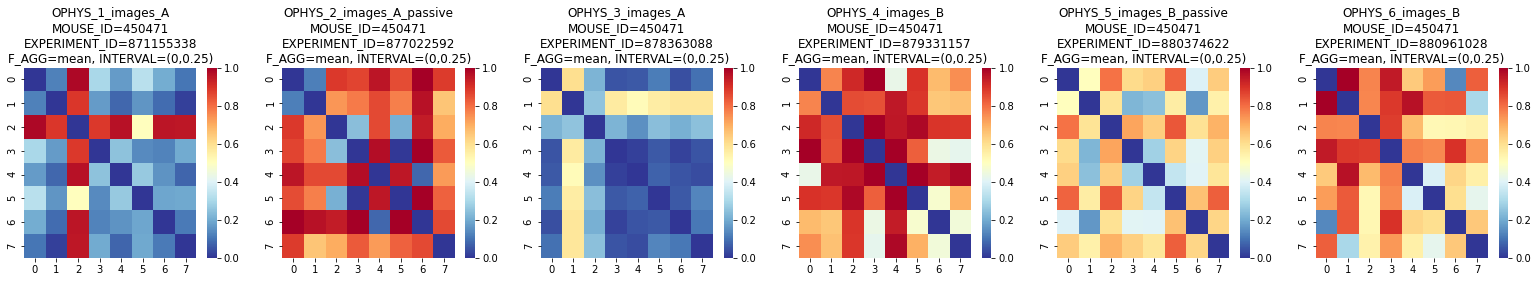

In [30]:
plot_RDM_with_dict(experiments_dict)

In [31]:
save_dict(experiments_dict)

Dict saved to logs/RDM/t=1626874308_F1_871155338_mean_0_0.25.dict
Dict saved to logs/RDM/t=1626874308_F2_877022592_mean_0_0.25.dict
Dict saved to logs/RDM/t=1626874308_F3_878363088_mean_0_0.25.dict
Dict saved to logs/RDM/t=1626874308_N1_879331157_mean_0_0.25.dict
Dict saved to logs/RDM/t=1626874308_N2_880374622_mean_0_0.25.dict
Dict saved to logs/RDM/t=1626874308_N3_880961028_mean_0_0.25.dict


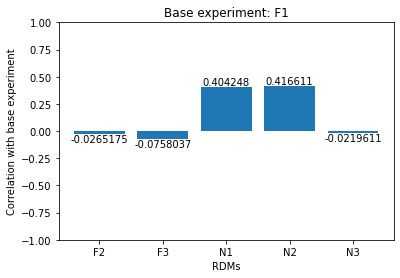

In [32]:
plot_RDM_correlations_with_dict(experiments_dict, "F1")